In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "10:30:00"
NUM_CLUSTER = 60
TIME_STEP = 5

In [3]:
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
# def load_data(date_begin='20180612', date_end = '20180730', split_date_begin = '20180801', split_date_end = '20180830', train = True):
    X = []
    Y = []
    h1, m1, s1 = [int(x) for x in BEGIN_TIME.split(":")]
    h2, m2, s2 = [int(x) for x in END_TIME.split(":")]
    t1 = dt.timedelta(hours = h1, minutes=m1)
    t2 = dt.timedelta(hours = h2, minutes=m2)
    total_mins = (t2-t1).total_seconds()//60
    
    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "close"]
                if len(front_df) == (total_mins // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

# def dtw_d(X, Y):
#     manhattan_distance = lambda x, y: np.abs(x - y)
#     d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
#     return d

# def dtw_affinity(X):
#     return pairwise_distances(X, metric=dtw_d)

# def fastdtw_d(X, Y):
#     return fastdtw(X, Y, dist=euclidean)[0]

# def fastdtw_affinity(X):
#     return pairwise_distances(X, metric=fastdtw_d)

def show_clustering(X, X_label):
    for n in range(NUM_CLUSTER):
        plt.title(n)
        for i in range(len(X)):
        #     plt.subplot(10, 1, X_label[i]+1)
            if X_label[i] == n:
                plt.plot(X[i])
        plt.show()
def train(max_iter = 300, n_clusters = 50):
    t1 = time.time()
    km = TimeSeriesKMeans(max_iter = max_iter, n_clusters=n_clusters, metric="dtw", n_jobs=5)
    X_label = km.fit_predict(X)
    t2 = time.time()
    print("training time", t2-t1)
    return km

def make_long_simple(y, cost):
    return y.max(),   y[0] * (1 + cost)
def make_short_simple(y, cost):
    return y[0], y.min() * (1 + cost)
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0], - y.max() - cost

def make_long(y, cost, exp_profit):
    if (y- (y[0] * (1+cost)) >= exp_profit).any():
        return y[0] *( 1 + exp_profit),   y[0] * (1 + cost)
    else:
        return y[-1],   y[0] * (1 + cost)
    
def make_short(y, cost, exp_profit):
    if (y[0] - y >=  y[0] * (exp_profit + cost)).any():
        return y[0] * (1-cost), y[0] * (1-exp_profit) 
    else:
        return y[0] * (1-cost), y[-1]
    
# def evaluate_km(X_test, Y_test, X_label, exp_profit=0.025):
#     profit_long_array = np.zeros(NUM_CLUSTER)
#     profit_short_array = np.zeros(NUM_CLUSTER)
#     cost_long_array = np.zeros(NUM_CLUSTER)
#     cost_short_array = np.zeros(NUM_CLUSTER)
#     num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
#     for i in range(len(X_test)):
#     #     p, l = make_long_simple(Y[i], 0.002)
#     #     profit_long_array[X_label[i]] += p
#     #     cost_short_array[X_label[i]] += l
#         p, c = make_short(Y_test[i], 0.002, exp_profit)
#         profit_short_array[X_label[i]] += p
#         cost_short_array[X_label[i]] += c
#         num_exchange_array[X_label[i]] += 1
#     return profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array

def evaluate_km_outsample(X_test, Y_test, exp_profit=0.025, cost = 0.002):
    y_test_pred =  km.predict(X_test.reshape(len(X_test), len(X_test[0]), 1))
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    cost_long_array = np.zeros(NUM_CLUSTER)
    cost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X_test)):
    #     p, l = make_long_simple(Y[i], 0.002)
    #     profit_long_array[X_label[i]] += p
    #     cost_short_array[X_label[i]] += l
        p, c = make_short(Y_test[i], cost, exp_profit)
        profit_short_array[y_test_pred[i]] += p
        cost_short_array[y_test_pred[i]] += c
        num_exchange_array[y_test_pred[i]] += 1
    avg_sin_profit = (profit_short_array-cost_short_array)/cost_short_array/num_exchange_array
    avg_sin_profit[np.isnan(avg_sin_profit)] = 0
    s = 0
    n = 0
    for i in range(5):
        j = best_short_cluster[i]
        s += avg_sin_profit[j] * num_exchange_array[j]
        n += num_exchange_array[j]
    print(s/n)
    return avg_sin_profit, num_exchange_array

def evaluate_km(X, Y, exp_profit, km, cost = 0.002):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    cost_long_array = np.zeros(NUM_CLUSTER)
    cost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X)):
        p, c = make_short(Y[i], cost, exp_profit)
        profit_short_array[X_label[i]] += p
        cost_short_array[X_label[i]] += c
        num_exchange_array[X_label[i]] += 1
    best_short_cluster = np.argsort((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1]
    avg_sin_profit = (profit_short_array-cost_short_array)/cost_short_array/num_exchange_array
    avg_sin_profit[np.isnan(avg_sin_profit)] = 0
    s = 0
    n = 0
    for i in range(5):
        j = best_short_cluster[i]
        s += avg_sin_profit[j] * num_exchange_array[j]
        n += num_exchange_array[j]
    print(s/n)
    return avg_sin_profit, num_exchange_array, s/n

def select_best(num_best, avg_profit_array, num_exchange_array):
    s = 0
    n = 0
    best_short_cluster = np.argsort(avg_profit_array)[::-1]
    for i in range(num_best):
        j = best_short_cluster[i]
        s += avg_profit_array[j] * num_exchange_array[j]
        n += num_exchange_array[j]
    print(s/n)    

In [4]:
X, Y = load_data()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:55<00:00,  8.88s/it]


In [5]:
X_test, Y_test = load_data(train=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.86s/it]


In [6]:
km = train(n_clusters = NUM_CLUSTER)

training time 650.1759252548218


In [7]:
X_label = km.predict(X)

c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2990 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


pickle.dump(km, open("km.pk", 'wb'))

km = pickle.load(open("km.pk", 'rb'))

km = pickle.load(open("km.pk", 'rb'))
X = pickle.load(open(os.path.join('dataset_pk',"X_ts.pk"), 'rb'))
Y = pickle.load(open(os.path.join('dataset_pk',"Y_ts.pk"), 'rb'))
X_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))
Y_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))

X_label

# 樣本內

In [8]:
pa, na, ap = evaluate_km(X, Y, 0.015, km)

0.0004908032497205116


In [9]:
pa, na, ap = evaluate_km(X, Y, 0.02, km)

0.0006754212812595123


In [28]:
sorted(pa)

[-0.02753023255813959,
 -0.007156271418780008,
 -0.005240259740259754,
 -0.004015890971773303,
 -0.0027570660387305278,
 -0.0024938785173159957,
 -0.0020000000000000144,
 -0.001528292961567981,
 -0.0012311481621826539,
 -0.0010724864413850367,
 -0.001043916011703301,
 -0.0010310603074497578,
 -0.0009619949954017487,
 -0.0007538376502525731,
 -0.00072732895013361,
 -0.0006914644717361709,
 -0.0006726569515878844,
 -0.0004998644678715644,
 -0.0004886571276883259,
 -0.0002614267837628161,
 -0.00021263211812185887,
 -0.00018524446815763713,
 -0.00016887544370663252,
 -0.00013430100443158883,
 -0.00011348887331099261,
 -5.47492688850576e-05,
 -4.477319096920218e-05,
 -4.167341059835608e-05,
 -3.607225549248913e-05,
 -6.229107912483856e-06,
 -9.046601414882325e-07,
 0.0,
 1.34677153184248e-05,
 1.3677638886995682e-05,
 4.07873864000786e-05,
 4.229869039323643e-05,
 4.577818156872645e-05,
 7.971653569170492e-05,
 8.55250886029019e-05,
 8.956484513300969e-05,
 0.00015006452412947202,
 0.000153

In [10]:
pa, na, ap = evaluate_km(X, Y, 0.025, km)

0.0007629417775069319


In [11]:
pa, na, ap= evaluate_km(X, Y, 0.03, km)

0.0008560307006824217


In [50]:
select_best(3, pa, na)

0.000609615712666886


In [51]:
select_best(5, pa, na)

0.0004081253252281593


# 樣本外

In [13]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.015, km)

0.0024141424592948294


c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [12]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.02, km)

0.0031187391579243656


c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [14]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.025, km)

0.003827663243375424


c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [15]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.03, km)

0.004540957485240536


c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [16]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.035, km)

0.005258665245469665


c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [17]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.04, km)

0.0059808304889893285


c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


In [18]:
pa, na, ap = evaluate_km(X_test, Y_test, 0.45, km)

c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


0.006499977132907474


In [53]:
select_best(5, pa, na)

0.0030081502282444297


In [20]:
sp = np.linspace(0.01, 0.1, 20)

In [27]:
sp

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [26]:
for i in range(len(sp)):
    pa, na, y = evaluate_km(X_test, Y_test, sp[i], km)
    index = np.argsort(pa)[::-1]
    print(na[index[0]]+na[index[1]]+na[index[2]])
#     plt.scatter(sp[i], y)

c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in true_divide
c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


0.0015232314919871451
9
0.0023771774925611237
9
0.003044368038305491
9
0.003715438429149578
9
0.004390424965060184
9
0.005069364421822352
10
0.005752294059110545
10
0.006451769275121311
10
0.006668996627189693
10
0.007157613272258314
10
0.007159902565412644
10
0.00631737353868997
10
0.006523754293810269
10
0.006730837340639815
10
0.006499977132907474
10
0.006499977132907474
10
0.006499977132907474
10
0.006499977132907474
10
0.006499977132907474
10
0.006499977132907474
10


In [81]:
sp

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [55]:
X_label = km.predict(X)

c:\users\ken32\appdata\local\programs\python\python37\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2990 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


TypeError: show_clustering() takes 0 positional arguments but 2 were given

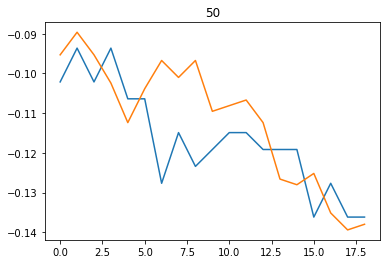

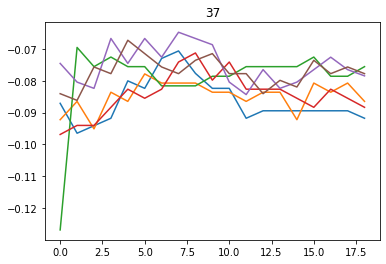

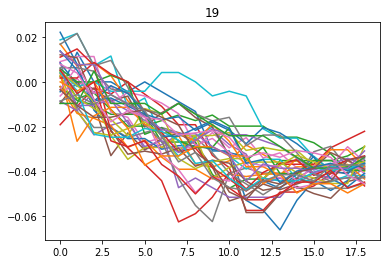

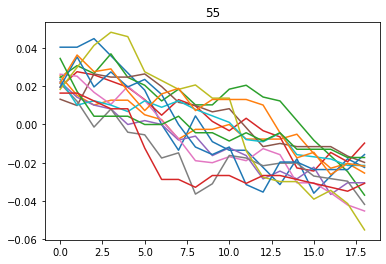

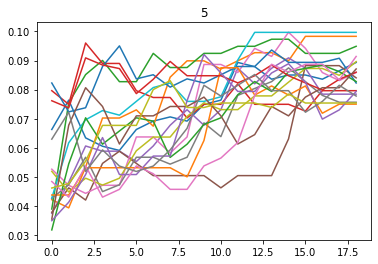

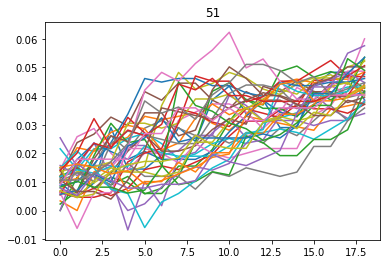

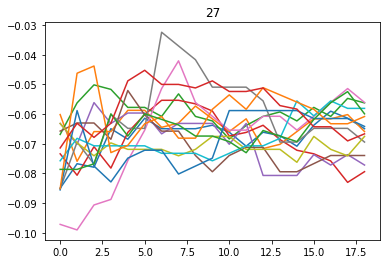

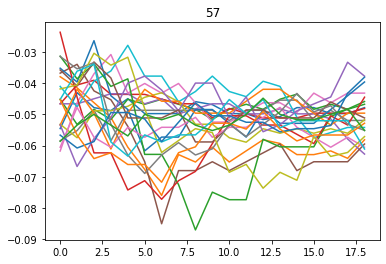

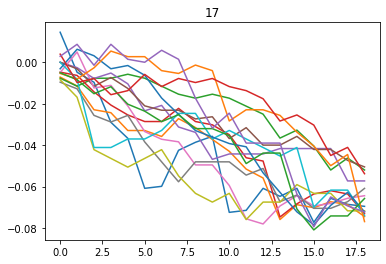

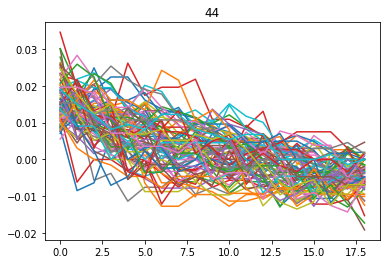

In [54]:
best_short_cluster = np.argsort(pa)[::-1]
for n in range(10):
    plt.title(best_short_cluster[n])
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == best_short_cluster[n]:
            plt.plot(X[i])
    plt.show()

In [ ]:
print()